In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from datasets import load_dataset
from tensorflow.image import resize

In [2]:
# Load the Retinamnist dataset
ds = load_dataset("albertvillanova/medmnist-v2", "retinamnist", trust_remote_code=True)

# Convert the dataset to NumPy arrays
def preprocess_data(dataset, target_size=(224, 224)):
    images = np.array([item['image'] for item in dataset])
    labels = np.array([item['label'] for item in dataset])
    images = np.array([resize(image, target_size).numpy() for image in images])  # Resize images
    images = images.astype('float32') / 255.0  # Normalize pixel values
    return images, labels

x_train, y_train = preprocess_data(ds['train'])
x_test, y_test = preprocess_data(ds['test'])

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 5)
y_test = tf.keras.utils.to_categorical(y_test, 5)

In [3]:
# Define the ResNet50 model with the weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the optimizer with a learning rate of 5e-5
optimizer = Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
34/34 [==============================] - 51s 1s/step - loss: 1.4552 - accuracy: 0.4287 - val_loss: 1.4011 - val_accuracy: 0.4350
Epoch 2/10
34/34 [==============================] - 46s 1s/step - loss: 1.4162 - accuracy: 0.4500 - val_loss: 1.4111 - val_accuracy: 0.4350
Epoch 3/10
34/34 [==============================] - 49s 1s/step - loss: 1.4179 - accuracy: 0.4500 - val_loss: 1.4060 - val_accuracy: 0.4350
Epoch 4/10
34/34 [==============================] - 46s 1s/step - loss: 1.4147 - accuracy: 0.4500 - val_loss: 1.4029 - val_accuracy: 0.4350
Epoch 5/10
34/34 [==============================] - 48s 1s/step - loss: 1.4197 - accuracy: 0.4500 - val_loss: 1.4104 - val_accuracy: 0.4350
Epoch 6/10
34/34 [==============================] - 47s 1s/step - loss: 1.4173 - accuracy: 0.4500 - val_loss: 1.4318 - val_accuracy: 0.4350
Epoch 7/10
34/34 [==============================] - 49s 1s/step - loss: 1.4153 - accuracy: 0.4500 - val_loss: 1.4007 - val_accuracy: 0.4350
Epoch 8/10
34/34 [==

In [4]:
# Evaluate the model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

13/13 [==============================] - 14s 979ms/step


In [5]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.4350
Precision: 0.1892
Recall: 0.4350
F1 Score: 0.2637


D:\CSE299\Flutter\Anaconda\envs\A_prediction\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


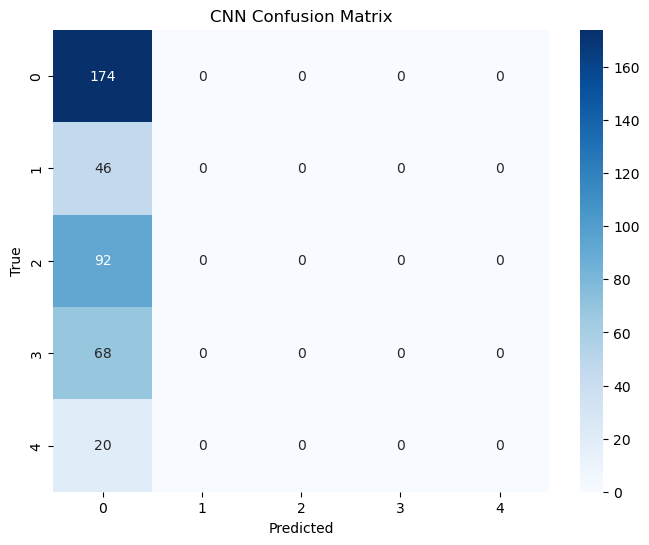

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the confusion matrix plot

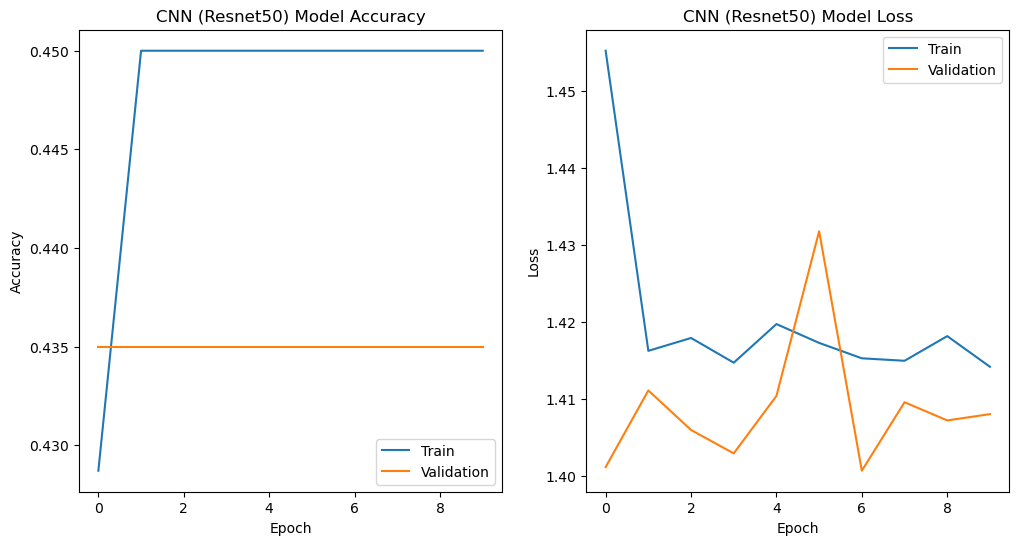

In [7]:
# Accuracy Curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN (Resnet50) Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN (Resnet50) Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.savefig('accuracy_loss_curves.png')  # Save the accuracy and loss curves plot


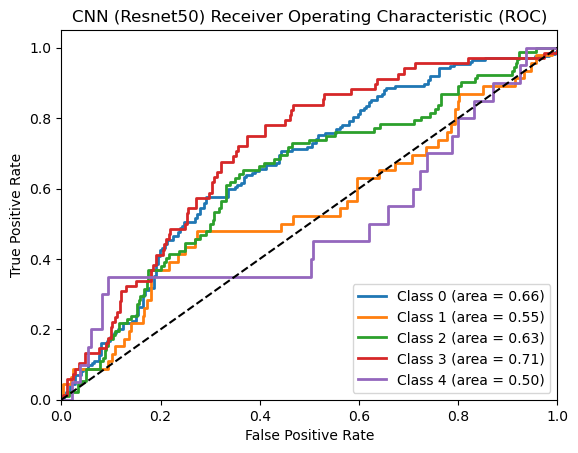

In [8]:
# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN (Resnet50) Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')  # Save the ROC curve plot